In [1]:
import pandas as pd
import cv2
import numpy as np
import os 

df = pd.read_csv('/kaggle/input/sssasdasd/train/_annotations.csv')
image_dir = '/kaggle/input/sssasdasd/train'
images = []
labels = []
bboxes = []

for _, row in df.iterrows():
   
    try:
        img_path = os.path.join(image_dir, row['filename'])
        img = cv2.imread(img_path)

       
        img = cv2.resize(img, (224, 224)) / 255.0
        images.append(img)
        label = 0 if row['class'] == 'fork' else 1
        labels.append(label)


    except Exception as e:
        print(str(e))
 


    # Normalize bounding boxes
    bbox = [
        row['xmin'] / row['width'],
        row['ymin'] / row['height'],
        row['xmax'] / row['width'],
        row['ymax'] / row['height']
    ]
    bboxes.append(bbox)

X = np.array(images)
y_class = np.array(labels)
y_bbox = np.array(bboxes)


In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K

def iou_metric(y_true, y_pred):
    """
    IoU metriğini hesaplar.
    y_true: Gerçek bounding box değerleri [x_min, y_min, x_max, y_max]
    y_pred: Tahmin edilen bounding box değerleri [x_min, y_min, x_max, y_max]
    """
    # Gerçek ve tahmin edilen bounding box'ların koordinatları
    x_min = K.maximum(y_true[:, 0], y_pred[:, 0])
    y_min = K.maximum(y_true[:, 1], y_pred[:, 1])
    x_max = K.minimum(y_true[:, 2], y_pred[:, 2])
    y_max = K.minimum(y_true[:, 3], y_pred[:, 3])
    
    # Kesişim alanı
    intersection = K.maximum(x_max - x_min, 0) * K.maximum(y_max - y_min, 0)
    
    # Gerçek ve tahmin edilen bounding box alanları
    true_area = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    pred_area = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])
    
    # Birleşim alanı
    union = true_area + pred_area - intersection
    
    # IoU hesaplama
    iou = intersection / K.maximum(union, K.epsilon())
    return K.mean(iou)


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19

# Giriş boyutları
img_width, img_height = 224, 224

# Pre-trained VGG19 modeli
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Pre-trained katmanları dondur
for layer in base_model.layers:
    layer.trainable = False

# Modelin üst kısmını oluştur
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Sınıf tahmini (Sigmoid aktivasyonu ile ikili sınıflandırma)
class_output = Dense(1, activation='sigmoid', name='class_output')(x)

# Bounding box tahmini
bbox_output = Dense(4, activation='linear', name='bbox_output')(x)

# Modelin giriş ve çıkışları
model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])

# Modelin derlenmesi
model.compile(
    loss={
        'class_output': 'binary_crossentropy',
        'bbox_output': 'mean_squared_error'
    },
    optimizer=Adam(learning_rate=0.001),
    metrics={
        'class_output': ['accuracy'],
        'bbox_output':  [iou_metric]
    }
)

# Model özeti
model.summary()

# Eğitim
history = model.fit(
    X,  # Giriş görüntüleri
    {
        'class_output': y_class,  # Sınıf etiketleri
        'bbox_output': y_bbox  # Bounding box koordinatları
    },
    validation_split=0.2,
    epochs=100,
    batch_size=32
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv4 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv4 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)

 Total params: 20,026,949 (76.40 MB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 729ms/step - bbox_output_iou_metric: 0.1407 - class_output_accuracy: 0.4239 - loss: 1.0673 - val_bbox_output_iou_metric: 0.2648 - val_class_output_accuracy: 0.4694 - val_loss: 0.7561
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - bbox_output_iou_metric: 0.2627 - class_output_accuracy: 0.5290 - loss: 0.7388 - val_bbox_output_iou_metric: 0.2503 - val_class_output_accuracy: 0.4694 - val_loss: 0.7524
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - bbox_output_iou_metric: 0.2402 - class_output_accuracy: 0.5992 - loss: 0.7100 - val_bbox_output_iou_metric: 0.3798 - val_class_output_accuracy: 0.4694 - val_loss: 0.7271
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - bbox_output_iou_metric: 0.3442 - class_output_accuracy: 0.6301 - loss: 0.6646 - val_bbox_output_iou_metric: 0.4114 - val_class_output_accuracy: 0.5612 - val_loss: 0.6946
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - bbox_output_iou_metric: 0.3593 - class_output_

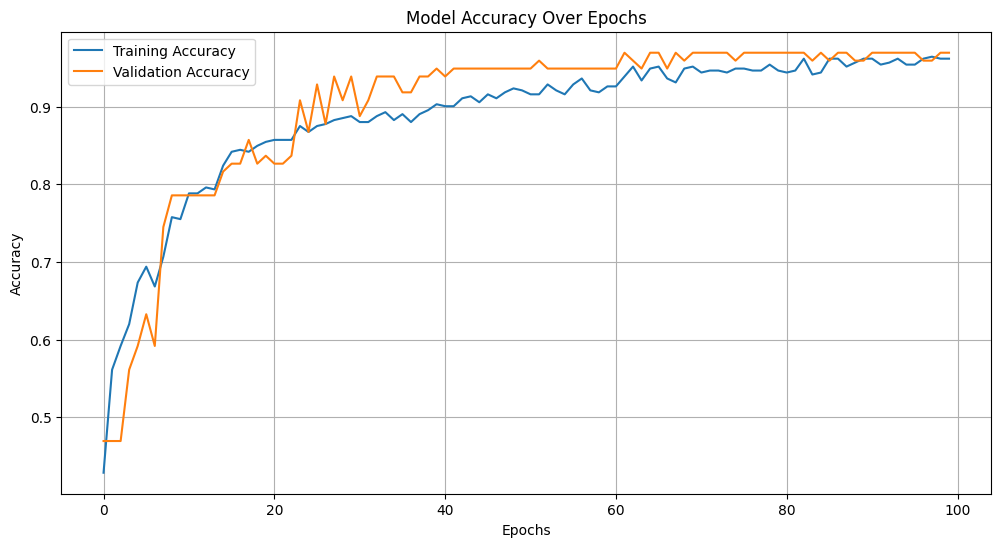

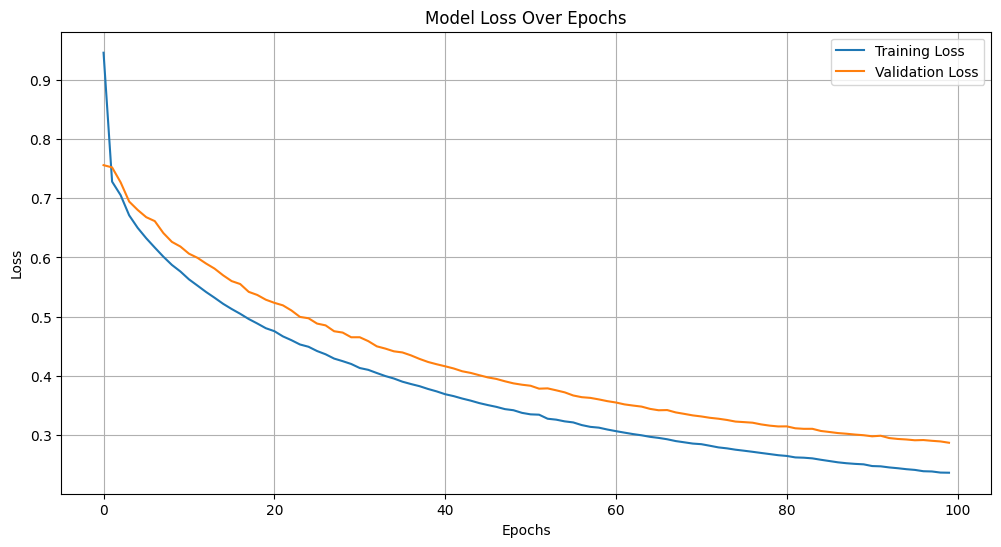

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Eğitim ve doğrulama kaybı (loss)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

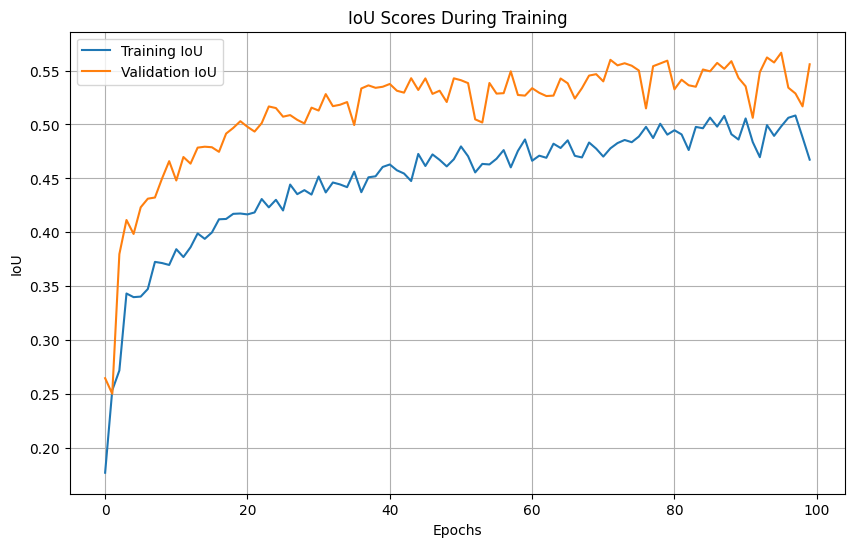

In [5]:
import matplotlib.pyplot as plt

# IoU Skorları (Eğitim ve Doğrulama)
train_iou = history.history['bbox_output_iou_metric']
val_iou = history.history['val_bbox_output_iou_metric']

# Grafik
plt.figure(figsize=(10, 6))
plt.plot(train_iou, label='Training IoU')
plt.plot(val_iou, label='Validation IoU')
plt.title('IoU Scores During Training')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid()
plt.show()


In [6]:
def iou_metric(y_true, y_pred):
    x_min = tf.maximum(y_true[:, 0], y_pred[:, 0])
    y_min = tf.maximum(y_true[:, 1], y_pred[:, 1])
    x_max = tf.minimum(y_true[:, 2], y_pred[:, 2])
    y_max = tf.minimum(y_true[:, 3], y_pred[:, 3])

    intersection = tf.maximum(x_max - x_min, 0) * tf.maximum(y_max - y_min, 0)
    true_area = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    pred_area = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])
    union = true_area + pred_area - intersection

    iou = intersection / tf.maximum(union, tf.keras.backend.epsilon())
    return tf.reduce_mean(iou)


In [7]:
y_bbox_pred = model.predict(X)[1]
iou_scores = []

for true_bbox, pred_bbox in zip(y_bbox, y_bbox_pred):
    intersection = np.maximum(0, np.minimum(true_bbox[2], pred_bbox[2]) - np.maximum(true_bbox[0], pred_bbox[0])) * \
                   np.maximum(0, np.minimum(true_bbox[3], pred_bbox[3]) - np.maximum(true_bbox[1], pred_bbox[1]))
    union = (true_bbox[2] - true_bbox[0]) * (true_bbox[3] - true_bbox[1]) + \
            (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1]) - intersection
    iou_scores.append(intersection / (union + 1e-6))

mean_iou = np.mean(iou_scores)
print(f"Mean IoU: {mean_iou}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step
Mean IoU: 0.4975666272514149
